<a href="https://colab.research.google.com/github/iceQHdrop/bioinformatic_data_mining/blob/main/ML_for_donar_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML for donar finding

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp -r drive/MyDrive/Colab_Notebooks/bioinformatic_data_mining/dataset ./

In [105]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

## 数据读取

### 设定路径名

In [3]:
train_path = 'dataset/TrainingSet'
test_path = 'dataset/TestingSet'    
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)


### 读取训练数据

#### 定义读取函数

In [4]:
def LoadData(files, file_path):
    site_seqs = []
    normal_seqs = []

    print(f'Loading data from {file_path}...')

    for file in tqdm(files):
        with open(file_path + '/' + file, 'r') as f:
            text = f.readlines()
            site_positions = re.findall('(\d+)(?=,)', text[1])    # 提取位置
            seq = ''.join(text[2:]).replace('\n', '').lower()
        
            for position in site_positions:
                site_seqs.append(seq[int(position) - 4:int(position) + 5])
                
            for position in range(len(seq) - 8):
                normal_seq = seq[position:position+9]
                
                if normal_seq not in site_seqs and \
                    set(normal_seq) == {'a', 't', 'c', 'g'}:
                    normal_seqs.append(normal_seq)
        
            # for num in range(4):    # 提取非位点序列
            #     normal_position = np.random.randint(len(seq) - 9)    # 采样至倒数第九位
            #     normal_seq = seq[normal_position - 4:normal_position + 5]

            #     while normal_position in site_positions or \
            #         set(normal_seq) != {'a', 't', 'c', 'g'} or \
            #         len(normal_seq) != 9:    # 排除donar位点与'n', 'm' 等

            #         normal_position = np.random.randint(len(seq) - 9)
            #         normal_seq = seq[normal_position - 4:normal_position + 5]

            #     normal_seqs.append(normal_seq)
    
    site_df = pd.DataFrame(list(zip(site_seqs, np.ones(len(site_seqs)))),    # 位点
                            columns = ['Seq', 'Donar'])

    normal_df = pd.DataFrame(list(zip(normal_seqs, np.zeros(len(normal_seqs)))),    # 非位点
                              columns = ['Seq', 'Donar'])

    df = pd.concat([site_df, normal_df]).reset_index(drop = True)

    return df
  

#### 读取数据   

In [5]:
train_df = LoadData(train_files, train_path)
test_df = LoadData(test_files, test_path)

Loading data from dataset/TrainingSet...


100%|██████████| 462/462 [01:43<00:00,  4.46it/s]


Loading data from dataset/TestingSet...


100%|██████████| 570/570 [00:56<00:00, 10.08it/s]


## 特征提取

### One-hot 编码

In [6]:
X_train = train_df['Seq'].str.split('', expand = True).iloc[:, 1:10]
X_train = pd.get_dummies(X_train)
y_train = train_df['Donar']
X_train

,1_a,1_c,1_g,1_t,2_a,2_c,2_g,2_t,3_a,3_c,...,7_g,7_t,8_a,8_c,8_g,8_t,9_a,9_c,9_g,9_t
0,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212062,0,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3212063,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
3212064,0,0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
3212065,0,0,1,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0


In [7]:
X_test = test_df['Seq'].str.split('', expand = True).iloc[:, 1:10]
X_test = pd.get_dummies(X_test)
y_test = test_df['Donar']
X_test.head()
y_test.shape

(1702069,)

## SVM

In [9]:
clf = SVC()

In [10]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [109]:
# result_df = pd.DataFrame({'Donar': y_test, 'Pred': y_pred})
# result_df.to_csv('SVM_test_df.csv')
result_df = pd.read_csv('SVM_test_df.csv', index_col = 0)

### F1-score

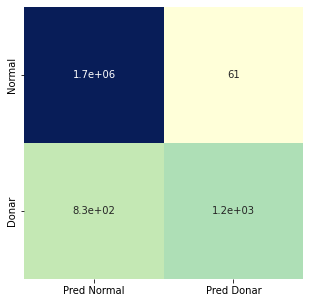

In [110]:
svm_f1 = f1_score(result_df['Donar'], result_df['Pred'])
svm_mat = confusion_matrix(result_df['Donar'], result_df['Pred'])

plt.figure(figsize = (5, 5))
svm_hm = sns.heatmap(np.log(svm_mat), 
                        annot = svm_mat, 
                        cmap = 'YlGnBu', 
                        xticklabels = ['Pred Normal', 'Pred Donar'],
                        yticklabels = ['Normal', 'Donar'],
                        cbar = False)

## CNN

### 确定设备

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The model will be running on {device}.')

The model will be running on cuda.


### 定义模型

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(1, 10, kernel_size = 3, padding = 1, stride = 1),
                                    nn.ReLU(True),
                                    nn.Conv2d(10, 20, kernel_size = 3, padding = 1, stride = 1),
                                    nn.ReLU(True),
                                    nn.Conv2d(20, 50, kernel_size = 3, padding = 1, stride = 1),
                                    nn.ReLU(True),
                                    nn.Flatten(),
                                    nn.Linear(4*9*50, 2))
        
    def forward(self, X):
        X = X.view(-1, 1, 9, 4)
        return self.layers(X)

### 模型结构

In [21]:
! pip install hiddenlayer
import hiddenlayer as h

cnn_vis = CNN()
vis_graph = h.build_graph(cnn_vis, torch.zeros([1 ,1, 9, 4])) 
vis_graph.save('model_fig')

/data4/zhanghaohong/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/module.py:720: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self._slow_forward(*input, **kwargs)


ModuleNotFoundError: No module named 'graphviz'

### 重新定义数据特征表示

#### 定义编码函数

In [26]:
def OneHot(seq):
    base_dict = {'a': 0, 't': 1, 'c': 2, 'g': 3}
    seq_list = [base_dict[base] for base in seq]
    seq_tensor = torch.tensor(seq_list)
    return F.one_hot(seq_tensor).tolist()

#### 编码

In [27]:
X_train_cnn = torch.tensor(train_df['Seq'].apply(OneHot).values.tolist(), 
                           dtype = torch.float)
X_test_cnn = torch.tensor(test_df['Seq'].apply(OneHot).values.tolist(), 
                          dtype = torch.float)
y_train_cnn = torch.tensor(train_df['Donar'])
y_test_cnn = torch.tensor(test_df['Donar'])
X_train_cnn[0]

tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])

### 装入DataSet

In [28]:
whole_train_set = TensorDataset(X_train_cnn, y_train_cnn)
test_set = TensorDataset(X_test_cnn, y_test_cnn)

### 定义训练函数

In [43]:
def train(whole_train_set):
    train_set, valid_set = random_split(whole_train_set, [int(0.8*len(whole_train_set)), len(whole_train_set) - int(0.8*len(whole_train_set))])
    train_loader = DataLoader(train_set, batch_size = 500, shuffle = True)
    # valid_loader = DataLoader(valid_set, batch_size = 500, shuffle = True)
    
    model = CNN()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    best_f1 = 0.0
    
    for epoch in range(200):
        running_train_loss = 0.0  

        for i, data in enumerate(train_loader, 0):
            X = data[0].to(device)
            y = data[1].to(device)
            optimizer.zero_grad()
            
            outputs = model(X)  
            loss = criterion(outputs, y.long())
            loss.backward()
            optimizer.step()
            running_train_loss += loss
        
        train_loss = running_train_loss/len(train_loader)
        
        with torch.no_grad():
            model.eval()
            
            X = valid_set[:][0].to(device)
            y = valid_set[:][1].to(device)
            outputs = model(X)
            val_loss = criterion(outputs, y.long())
            _, y_pred = torch.max(outputs, dim = 1)
            f1 = f1_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())        
        
        if f1 > best_f1:
            torch.save(model.state_dict(), f'./best_model.pth')
            print(f'The model has been saved for the best F1-score {f1}')
            best_f1 = f1
        
        if epoch == 0:
            print(f'The model is working fine! F1-score: {f1}')

        if (epoch + 1)%10 == 0:
            print(f'Completed training epoch', epoch + 1, 'Training Loss is: %.4f' %train_loss, 'Validation Loss is: %.4f' %val_loss, 'f1-score is {f1}')

### 训练

In [44]:
train(whole_train_set)

The model is working fine! F1-score: 0.0
The model has been saved for the best F1-score 0.36393442622950817
The model has been saved for the best F1-score 0.47647058823529415
The model has been saved for the best F1-score 0.5200553250345781
The model has been saved for the best F1-score 0.56158940397351
The model has been saved for the best F1-score 0.5809768637532133
Completed training epoch 10 Training Loss is: 0.0015 Validation Loss is: 0.0015 f1-score is {f1}
The model has been saved for the best F1-score 0.5985037406483791
The model has been saved for the best F1-score 0.6025
The model has been saved for the best F1-score 0.6072289156626506
The model has been saved for the best F1-score 0.6096385542168674
The model has been saved for the best F1-score 0.6108374384236454
Completed training epoch 20 Training Loss is: 0.0014 Validation Loss is: 0.0014 f1-score is {f1}
The model has been saved for the best F1-score 0.6121437422552665
The model has been saved for the best F1-score 0.62

In [81]:
def test(test_set):
    model = CNN()
    model.to('cpu')
    model.load_state_dict(torch.load(f'./best_model.pth'))
    model.eval()
    
    X = test_set[:][0].to('cpu')
    y = test_set[:][1].to('cpu')
    
    y_pred = F.softmax(model(X), 1)[:, 1]
    return pd.DataFrame({'Donar': y.cpu().detach().numpy(), 'Score': y_pred.cpu().detach().numpy()})

In [82]:
result_df = test(test_set)
result_df.to_csv('CNN_test_df.csv')
result_df = pd.read_csv('CNN_test_df.csv', index_col = 0)

In [85]:
cnn_f1 =  f1_score(result_df['Donar'], result_df['Score'].apply(lambda x: 1 if x > 0.5 else 0))
cnn_mat = confusion_matrix(result_df['Donar'], result_df['Score'].apply(lambda x: 1 if x > 0.5 else 0))
cnn_f1, cnn_mat

(0.758697467297523,
 array([[1699839,     151],
        [    716,    1363]]))

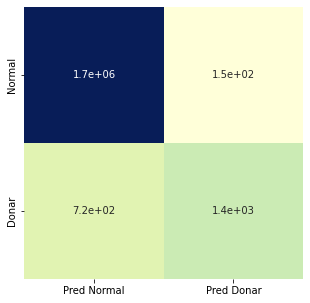

In [107]:
plt.figure(figsize = (5, 5))
cnn_hm = sns.heatmap(np.log(cnn_mat), 
                        annot = cnn_mat, 
                        cmap = 'YlGnBu', 
                        xticklabels = ['Pred Normal', 'Pred Donar'],
                        yticklabels = ['Normal', 'Donar'],
                        cbar = False)